In [2]:
# !pip install xmovie

In [3]:
import xesmf as xe
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from netCDF4 import Dataset
import urllib.request

## Loading in data

In [4]:
era5_data_path = "/vortexfs1/share/cmip6/data/era5/reanalysis/single-levels/monthly-means/"

#10m u-wind
u10m = xr.open_mfdataset(era5_data_path + "10m_u_component_of_wind/*.nc", 
                         engine = "netcdf4", parallel = True)
u10m = u10m - u10m.mean("time") #remove mean for filtering purposes

# Easy animations

In [120]:
data = u10m.u10.isel(time = slice(0, 100)).compute()

AttributeError: 'Dataset' object has no attribute 'u10m'

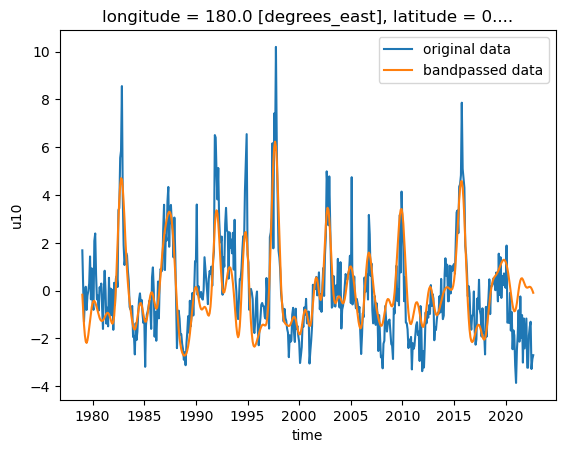

In [101]:
# Create movie object
data = ds.u10m.isel(time = slice(0, 100))
mov = Movie()

# Filtering a Hovmoller diagram 
Now, we select all points along the equator to retrieve a data set of dimensions (time, longitude). We can use ``xr.apply_ufunc`` to apply this function to our xarray dataset without looping. 

In [102]:
from functools import partial

#get data of all points along equator at all times
data = u10m["u10"].sel(latitude = 0).compute() 

fs = 1 #data is set in 1 month time steps 
highcut = 1 / 12 # only consider frequencies longer than 12 months 
lowcut  = 1 / (12 * 10) #only consider frequencies shorter than than 10 years
order=5

u10m_equator_time_series['u10_filtered'] = xr.apply_ufunc(
    partial(butter_bandpass_filter, lowcut, highcut, fs),
    data,
    dask="parallelized",
    input_core_dims=[["time"]], #specifices time as the target dimension
    output_core_dims=[["time"]], 
)

### Plotting spatial results
Let's go ahead and plot our unfiltered and filtered data and see what they look like.

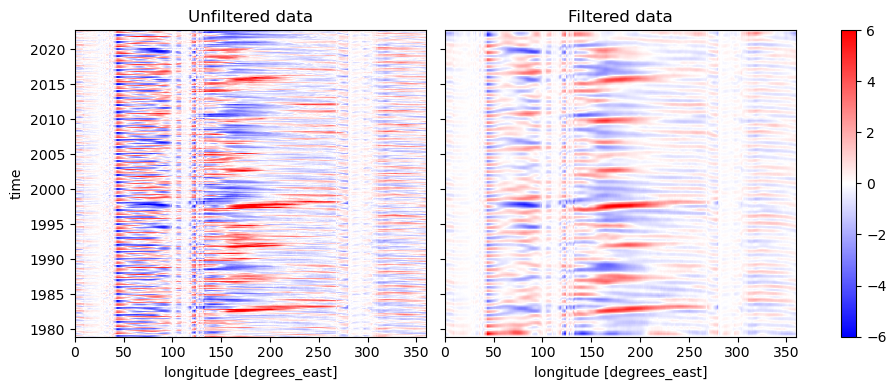

In [109]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

u10m_equator_time_series['u10'].compute().plot(ax = ax[0], add_colorbar = False, vmin = -6, vmax = 6, cmap = "bwr")
ax[0].set_title("Unfiltered data")

cb = u10m_equator_time_series['u10_filtered'].T.compute().plot(ax = ax[1], add_colorbar = False, vmin = -6, vmax = 6, cmap = "bwr")
ax[1].set_title("Filtered data"); ax[1].set_ylabel("")

fig.tight_layout()
fig.colorbar(cb, ax = ax, orientation = "vertical")

### Double checking our methods 
The results appear to be correctly filtered, but does this hold for individual time series? They do! This is a necessary step to make sure our computations are correct

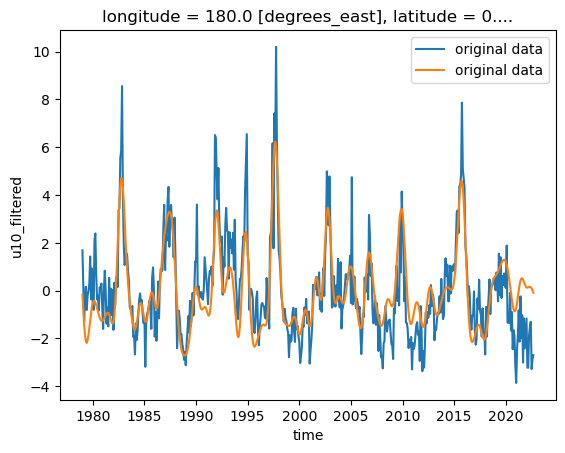

In [110]:
#double check the method is correct
u10m_equator_time_series["u10"].sel(longitude = 180).plot(label = "original data")
u10m_equator_time_series["u10_filtered"].sel(longitude = 180).plot(label = "original data")
plt.legend()

# Filtering a global dataset 
We've already practiced on subsets of our data. Let's try to do this with our whole dataset. We can still use ``xr.apply_ufunc`` to avoid looping, but now we must specify our datatype since ``u10m`` has not been computed yet (i.e. its been lazily loaded). We also have to rechunk our data since we require access to an entire time series for each point. This can be achieved by adding ``.chunk(dict(time=-1))`` to the end our dataset, which rechunks our data. 

In [111]:
from functools import partial

#get data of all points along equator at all times
data = u10m["u10"]

fs = 1 #data is set in 1 month time steps 
highcut = 1 / 12 # only consider frequencies longer than 12 months 
lowcut  = 1 / (12 * 10) #only consider frequencies shorter than than 10 years
order=5

u10m['u10_filtered'] = xr.apply_ufunc(
    partial(butter_bandpass_filter, lowcut, highcut, fs),
    data.chunk(dict(time=-1)),
    dask="parallelized",
    input_core_dims=[["time"]], #specifices time as the target dimension
    output_core_dims=[["time"]], 
    output_dtypes=[data.dtype]
)

### Checking that our original example is the same

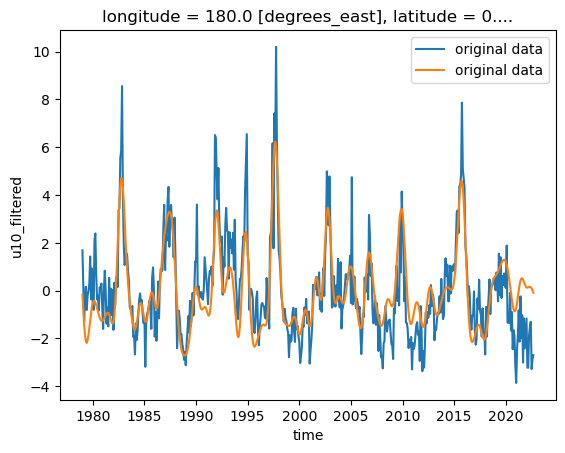

In [113]:
#double check the method is correct
u10m["u10"].sel(longitude = 180, latitude = 0).plot(label = "original data")
u10m["u10_filtered"].sel(longitude = 180, latitude = 0).plot(label = "original data")
plt.legend()

### Checking that Hovmoller diagram looks the same

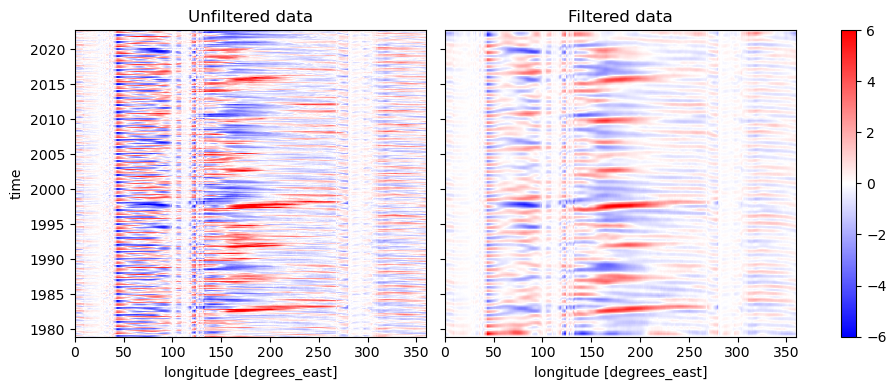

In [114]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

u10m['u10'].sel(latitude = 0).compute().plot(ax = ax[0], add_colorbar = False, vmin = -6, vmax = 6, cmap = "bwr")
ax[0].set_title("Unfiltered data")

cb = u10m['u10_filtered'].sel(latitude = 0).T.compute().plot(ax = ax[1], add_colorbar = False, vmin = -6, vmax = 6, cmap = "bwr")
ax[1].set_title("Filtered data"); ax[1].set_ylabel("")

fig.tight_layout()
fig.colorbar(cb, ax = ax, orientation = "vertical")